<a href="https://colab.research.google.com/github/musicjae/NLP/blob/master/Word2Vec/word2vec(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving sg1.png to sg1.png
User uploaded file "sg1.png" with length 86394 bytes


In [2]:
from IPython.display import Image

# 1. 반복iteration 기반 방법  
  
우리는 한 번에 한 iteration을 학습할 수 있는 모델을 만들고, 결국 그 문맥을 고려할 때 한 단어의 확률을 encode할 수 있다. 

## 1.1 Language Models (Unigrams, Bigrams, ...)  
  
좋은 언어 모델은 제대로 된 문장 (의미론적, 구문론적으로 완전한 문장)에 대해 높은 확률을 부여할 것이고, 그렇지 않은 문장에게는 낮은 확률을 부여할 것이다.  
  

- 임의의 주어진 n 개의 words의 열에 대한 probs:  
  
$$P(w1, ..., wn)$$  
  
- Unary Model: 일항unary 언어 모델은 단어의 나타남이 완전히 독립적이라고 가정한다.  
  
 
$$P(w1,...,wn) = \prod_{i=1}^{n} P(w_i)$$
  
한계: 이것은 다소 Ludicrous 하다. 왜냐하면 이전 words 시퀀스로부터 다음 word의 발생이 (이 경우에) 매우 우연적이기 때문이다.  
  
- Binary Model  
  
$$P(w1, ..., wn) = \prod_{i=2}^{n} P(w_i|w_{i-1})$$  
  
이것은 다소 Naive 하다. 이것은 전체 문장을 평가하기 보다는 이웃하는 단어들 간의 쌍pair에만 관심을 둔다. 또한, 이 방법은 word-word Matrix를 사용할 때 많은 계산량을 요구한다.

## 1.2 CBOW  
  
한 문장 내의 주변 단어로부터 중심 단어를 예측  



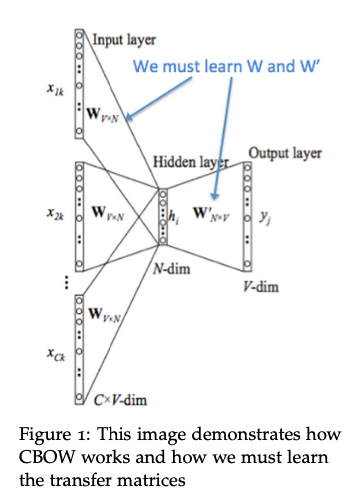

In [3]:
Image('cb1.png')

### [준비]  
  

$x^{(c)}$: 문맥에서 온 인풋 주변 단어  
$y^{(c)}$: 아웃풋 중심 단어  
$w_i$: V 내의 한 word i  
$M$: (V,n) 사이즈의 인풋 단어 행렬 (n은 임베딩 사이즈, V는 word size)// M의 i th 행에 대한 n 차원 embedded 벡터  
$U$: (n,V) 사이즈의 아웃풋 단어 행렬 // U의 j 열은 $w_j$에 대한 n 차원 embedded 벡터이다.

  
### [과정]  
  
- 1. window 사이즈에 대한 one-hot word vector인 M을 입력  
  
$$M = (x^{(c-m)}, ..., x^{(c+m)}) \in R^N$$  
  
- 2. Embedded word vectors for the context  
  
$$v_{c-m} = Vx^{c-m}, ..., v_{c-m+1}=Vx^{c-m+1}, ..., v_{c+m} \in R^n$$  
  
- 3. Average.  
$$\hat{v} = \frac{v_{c-m}+, ..., +v_{c+m}}{2m}$$  
- 4. Generate score vector.  
  
$$z = U\hat{v} \in R^{|V|}$$  
  
==> 유사한 단어들 간의 점곱은 더 높은 스코어를 갖고, 이는 그 단어들이 서로 가깝다는 것을 의미한다.  
  
- 5. 스코어 z를 소프트맥스화: 
$$\hat{y} = softmax(z)$$  
  
- 6. 우리가 5 에서 만든 확률인 $\hat{y}$와 실제 단어들의 참 확률인 y와 일치하는지 조사

  
### [Objective Function]  
  
목적 함수로 M, U를 학습시킨다. 이 목적 함수는 참 확률에서 (예측과 관련된) 어떤 확률을 학습시키고자 할 때, 두 분포 간의 거리를 측정해주는 정보 이론을 참고한다.  
  
$$H(\hat{y}, y) = - \sum_{j=1}^{|V|} y_j log(\hat{y_j})$$  
  
위 식을 참고할 때, 완벽한 예측의 경우에, $\hat{y}=1$이니까 H = 0  
낮은 신뢰도를 갖고 예측하는 경우에, 가령 $\hat{y}=0.01$ 이니까 H will be almost 4.6xx

  
### [Optimazation]  
  
minimize $J$  
  
  

 $= -log Prob(w_c | w_{c-m}, ... w_{c+m})$  
   

 $= -log Prob(u_c | \hat{v}) $   where $\hat{v}$는 위 과정 (3) 에서 구한 평균값  
   

 $= -log(\frac{exp(u_c^T \hat{v})}{\sum_{j=1}^|V| exp(u_j^T \hat{v})})$  
   

 $= -u_c^T\hat{v} + log \sum_{j=1}^{|V|} exp(u_j^T \hat{v})$



## 1.3 Skip-Gram

  
### [과정]  
  
- 1. One hot input vector $x$ (cener word)  
- 2. $v_c = Vx \in R^n$  
- 3. $z=Uv_c$ 스코어 벡터 생성  
- 4. $\hat{y} = softmax(z)$. 이제, $\hat{y}_{c-m},...,\hat{y}_{c+m}$은 각 context word을 관찰함으로써 얻은 확률이다.  
- 5. 생성된 확률 벡터가 $y^{c-m}, ..., y^{c+m}$인 참 확률과 일치하는지 조사

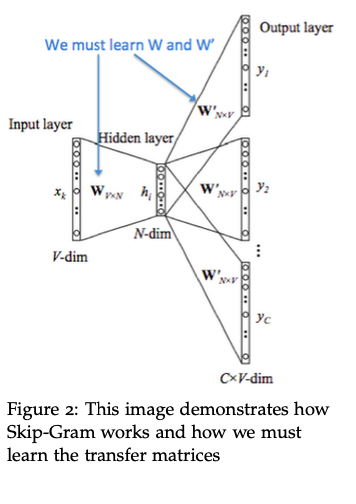

In [5]:
Image('sg1.png')

  
### [특징]  
  
CBOW와 다르게, prob를 break out 하기 위해 "Naive Bayes 가정"에 호소한다. 이 가정은 강력한 조건적 독립 가정이라고 간주될 수 있다. 여기서 'naive'라는 형용어가 붙은 이유는 모든 데이터셋 내의 특성features가 동등하고 서로 독립적이기 때문이다.

  
### [최적화]  
  
Minimize J  
$= -log Prob(w_{c-m}, ..., w_{c+m} | w_c)$  

$= -log(\prod_{j=0,j\ne m}^{2m} Prob(w_{c-m+j}|w_c)$  

$= -log(\prod_{j=0,j\ne m}^{2m} Prob(u_{c-m+j}|v_c)$  
  

$= -log(\prod_{j=0,j\ne m}^{2m} \frac{exp(u_{c-m+j}^T v_c)}{\sum_{k=1}^{|V|} exp(u_k^Tv_c)})$  

References  
  
[1] https://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf  
[2] https://gomguard.tistory.com/69